**Google Colab Code Link:**
https://colab.research.google.com/drive/1PnKpGMC8fWJY7qLGu2Xz2H_pBzrzhtbe?usp=sharing

# Image Inpainting — Classical PDE-based approach

**About the code**
- Auto-detects bright/missing regions (mask) from the input image
- Fills missing pixels using a directional-weighted fast-marching style propagation
- Refines the filled region with an edge-preserving diffusion
- Supports RGB, grayscale, and RGBA input images (alpha will be stripped)

**How to use**
- Upload an image to the runtime, set `image_path` in the Run cell, and execute cells in order.
- The notebook will display intermediate outputs (mask) and final image.


In [24]:
# Imports and utilities
import numpy as np
import cv2
import heapq
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

Following cell will defines two helper functions:

`load_and_convert(image)`: ensures the input becomes a three-channel BGR image (converts grayscale and removes alpha if present).

`create_white_mask(gray)`: produces a conservative binary mask for very bright/white missing areas (threshold + small morphology).

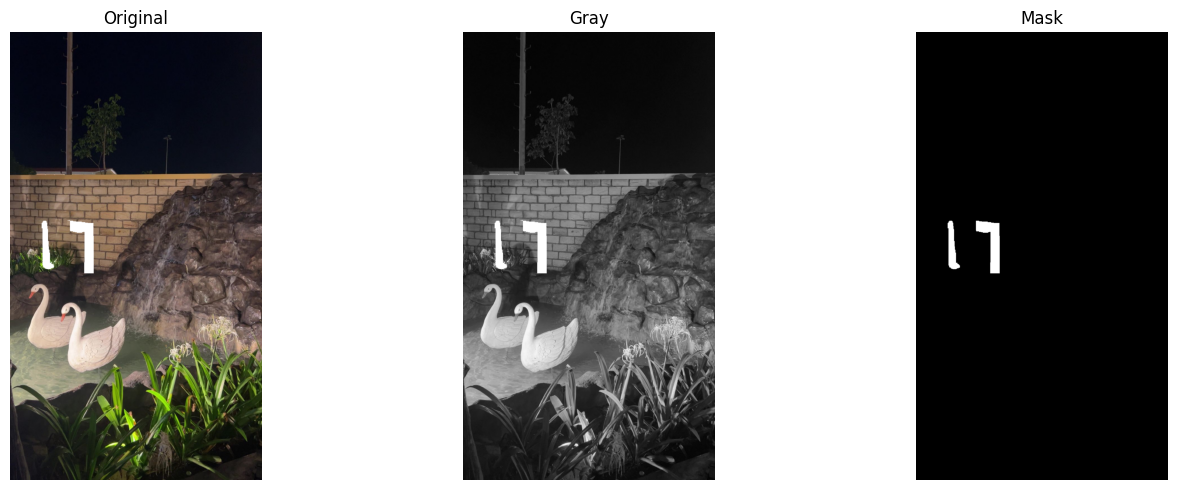

In [27]:
# Two helpers function: Input conversion and mask creation

# Load image (single input)
image_path = "/content/nature_n2.png" # Change image path as required
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

def load_and_convert(image):
    if image is None:
        raise ValueError("Image not found!")

    if len(image.shape) == 2:               # grayscale
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    elif image.shape[2] == 4:               # RGBA
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)

    return image

img_rgb = load_and_convert(image)


# Convert to grayscale
gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

def create_white_mask(gray):
    _, mask = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
    return (mask > 0).astype(np.uint8)

mask = create_white_mask(gray)


# -----------------------------------------------------------
# NEW: Show Original, Gray, Mask TOGETHER IN ONE ROW
# -----------------------------------------------------------

plt.figure(figsize=(15,5))

# 1. Original
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

# 2. Gray
plt.subplot(1, 3, 2)
plt.imshow(gray, cmap="gray")
plt.title("Gray")
plt.axis("off")

# 3. Mask
plt.subplot(1, 3, 3)
plt.imshow(mask, cmap="gray")
plt.title("Mask")
plt.axis("off")

plt.tight_layout()
plt.show()


Following cell defines the helper function that computes the direction-based weight used during pixel filling.

This helps:



*   preserve sharp edges
*   guide information smoothly from known → unknown regions
*   continue structures naturally inside the missing region



Mathematical idea

Let the target pixel be:
$ p = (p_x,\, p_y) $

Let a known neighbor pixel be:$q = (q_x,\, q_y)$

1. Direction vector from neighbor to target:

$
\vec{r} = (p_x - q_x,\; p_y - q_y)
$

2. Gradient direction at the neighbor:
$
\vec{g}_q = (g_x(q),\; g_y(q))
$
3. Alignment using dot product:
$
\text{dot} = \vec{r} \cdot \vec{g}_q
$

4. Distance-based decay:
$
r^2 = (p_x - q_x)^2 + (p_y - q_y)^2 + \epsilon
$
therfore,
$
r = \sqrt{r^2}
$

5. Final weight used for reconstruction:
$
w = \frac{\text{dot}}{r^2 \cdot r}
$

In [28]:
# Directional weighting function

def directional_weight(px, py, qx, qy, gx_q, gy_q):
    dx = px - qx
    dy = py - qy
    r2 = dx*dx + dy*dy + 1e-6
    r  = np.sqrt(r2)
    dot = dx * gx_q + dy * gy_q
    return dot / (r2 * r)


### **Explanation of `inpaint_custom` Function**

The `inpaint_custom` function performs image inpainting in **two stages**:
(1) **Fast-Marching–based filling**, and
(2) **Diffusion refinement**.
Below is the simplified explanation with key equations.


#### **1. Initial Setup**

* Pixels are labeled as:

  * `KNOWN` → outside mask
  * `BAND` → boundary of hole
  * `INSIDE` → deep inside hole

* A **distance transform** prioritizes pixels closer to known regions:
$
D(x,y)=\mathrm{distanceTransform(mask)}
$

* A **priority queue (min-heap)** pushes all BAND pixels using ( D(x,y) ) so nearer pixels fill first.

* Compute gradients using Sobel:
$
g_x = \frac{\partial I}{\partial x}, \qquad
g_y = \frac{\partial I}{\partial y}
$


#### **2. Fast Marching–Based Filling**

* Each step pops the pixel with **minimum distance** from the queue.

* For each missing pixel ((x,y)), the value is computed from known neighbors using a **gradient-guided weighted average**:
$
I(x,y) =
\frac{\sum_{(i,j)\in N} w_{ij}, I(i,j)}
{\sum_{(i,j)\in N} w_{ij}}
$

* Directional weight (conceptually):
$
w_{ij} = \frac{1}{1 + |\nabla I(i,j)|}
$

* If no good weights exist, median is used:
$
I(x,y)=\mathrm{median}(N)
$

* After filling, pixel becomes `KNOWN` and its `INSIDE` neighbors become `BAND`.

#### **3. Refinement (Anisotropic Diffusion)**

This step smooths artifacts while preserving edges.

* Compute gradient magnitude:
$
|\nabla I|=\sqrt{g_x^2+g_y^2}
$

* Diffusion coefficient (smooth more in flat areas):
$
c = \exp\left(-\left(\frac{|\nabla I|}{15}\right)^2\right)
$

* Four-direction flux:
$
\text{flux} =
c_N(I_N-I)+c_S(I_S-I)+c_E(I_E-I)+c_W(I_W-I)
$

* Update rule (inside mask only):
$
I_{\text{new}} = I + 0.18 \cdot \text{flux}
$

Repeated for ~40 iterations for a clean, coherent fill.



In [29]:
def inpaint_custom(image):
    img_rgb = load_and_convert(image)
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    mask = create_white_mask(gray)

    img = img_rgb.astype(np.float64)
    H, W, C = img.shape

    KNOWN, BAND, INSIDE = 0, 1, 2
    state = np.full((H, W), INSIDE, np.uint8)
    state[mask == 0] = KNOWN

    # Distance Transform
    dist = cv2.distanceTransform(mask.astype(np.uint8), cv2.DIST_L2, 3)

    # VISUALIZE: DISTANCE TRANSFORM
    plt.figure(figsize=(6,6))
    plt.imshow(dist, cmap='jet')
    plt.title("Distance Transform Map")
    plt.axis("off")
    plt.show()

    pq = []
    for y in range(H):
        for x in range(W):
            if mask[y, x] == 1:
                if ((y > 0 and mask[y-1, x] == 0) or (y < H-1 and mask[y+1, x] == 0) or
                    (x > 0 and mask[y, x-1] == 0) or (x < W-1 and mask[y, x+1] == 0)):
                    state[y, x] = BAND
                    heapq.heappush(pq, (dist[y, x], y, x))


    # VISUALIZE: BAND PIXELS
    band_vis = np.zeros((H, W, 3), dtype=np.uint8)
    band_vis[state == BAND] = [255, 0, 0]   # red = band
    band_vis[state == KNOWN] = [0, 255, 0]  # green = known
    band_vis[state == INSIDE] = [0, 0, 255] # blue = inside

    plt.figure(figsize=(6,6))
    plt.imshow(band_vis)
    plt.title("State Map (Known/Band/Inside)")
    plt.axis("off")
    plt.show()

    # Compute gradients
    gray_f = gray.astype(np.float64)
    gx = cv2.Sobel(gray_f, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray_f, cv2.CV_64F, 0, 1, ksize=3)
    grad_mag = np.sqrt(gx*gx + gy*gy)

    # VISUALIZE: gx, gy, and gradient magnitude

    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1); plt.imshow(gx, cmap="gray"); plt.title("gx"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(gy, cmap="gray"); plt.title("gy"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(grad_mag, cmap="inferno"); plt.title("Gradient Magnitude"); plt.axis("off")
    plt.show()

    neighbors = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]
    out = img.copy()

    print("Filling missing region...")

    #visualization before filling

    plt.figure(figsize=(6,6))
    plt.imshow(mask, cmap="gray")
    plt.title("Mask Before Filling")
    plt.axis("off")
    plt.show()

    # Fast-Marching filling loop
    while pq:
        _, y, x = heapq.heappop(pq)
        if state[y, x] == KNOWN:
            continue

        for c in range(C):
            Wsum = 0.0
            Isum = 0.0
            vals = []

            for dy, dx in neighbors:
                ny = y + dy; nx = x + dx
                if 0 <= ny < H and 0 <= nx < W and state[ny, nx] == KNOWN:
                    w = directional_weight(x, y, nx, ny, gx[ny, nx], gy[ny, nx])
                    if w > 0:
                        Wsum += w
                        Isum += w * out[ny, nx, c]
                    vals.append(out[ny, nx, c])

            out[y, x, c] = Isum/Wsum if Wsum > 0 else np.median(vals)

        state[y, x] = KNOWN

        for dy, dx in neighbors:
            ny = y + dy; nx = x + dx
            if 0 <= ny < H and 0 <= nx < W and state[ny, nx] == INSIDE:
                state[ny, nx] = BAND
                heapq.heappush(pq, (dist[ny, nx], ny, nx))

    print("Initial fill complete. Running refinement...")

    # VISUALIZE: After initial fill
    plt.figure(figsize=(6,6))
    plt.imshow(out.astype(np.uint8))
    plt.title("After Initial Fill (Before Refinement)")
    plt.axis("off")
    plt.show()

    # refinement
    mask_f = mask.copy()
    gray_r = gray_f.copy()

    for _ in range(40):
        gx = cv2.Sobel(gray_r, cv2.CV_64F, 1, 0, ksize=3)
        gy = cv2.Sobel(gray_r, cv2.CV_64F, 0, 1, ksize=3)
        grad = np.sqrt(gx*gx + gy*gy)
        c = np.exp(-(grad/15)**2)

        for k in range(3):
            I = out[..., k]

            north = np.zeros_like(I); north[1:, :] = I[:-1, :]
            south = np.zeros_like(I); south[:-1, :] = I[1:, :]
            east  = np.zeros_like(I); east[:, :-1] = I[:, 1:]
            west  = np.zeros_like(I); west[:, 1:] = I[:, :-1]

            cN = np.zeros_like(c); cN[1:, :]  = (c[1:, :] + c[:-1, :]) * 0.5
            cS = np.zeros_like(c); cS[:-1, :] = (c[1:, :] + c[:-1, :]) * 0.5
            cW = np.zeros_like(c); cW[:, 1:]  = (c[:, 1:] + c[:, :-1]) * 0.5
            cE = np.zeros_like(c); cE[:, :-1] = (c[:, 1:] + c[:, :-1]) * 0.5

            flux = cN*(north-I) + cS*(south-I) + cW*(west-I) + cE*(east-I)
            I_new = I + 0.18*flux
            out[..., k][mask_f == 1] = I_new[mask_f == 1]

            gray_r = cv2.cvtColor(out.astype(np.uint8), cv2.COLOR_BGR2GRAY).astype(np.float64)

    print("Refinement done.")

    # FINAL OUTPUT VISUALIZATION
    plt.figure(figsize=(6,6))
    plt.imshow(out.astype(np.uint8))
    plt.title("Final Inpainted Output")
    plt.axis("off")
    plt.show()

    return np.clip(out, 0, 255).astype(np.uint8)


Main loop

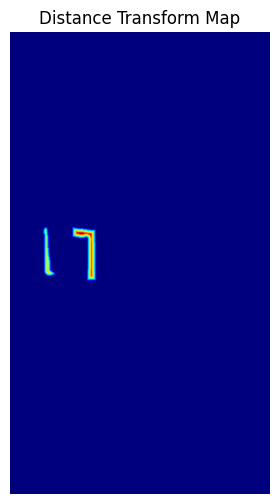

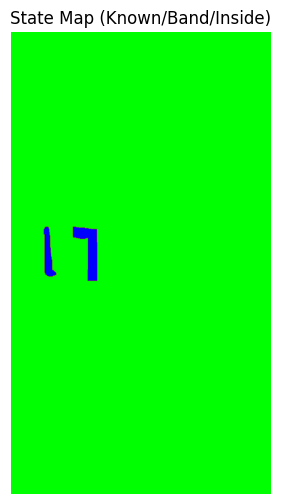

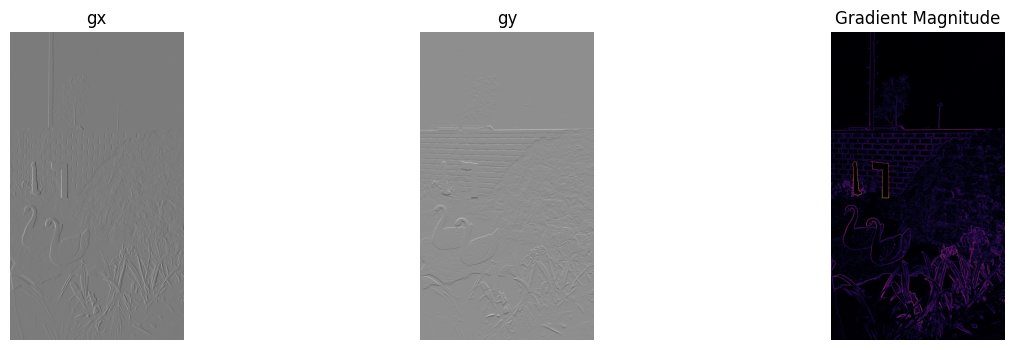

Filling missing region...


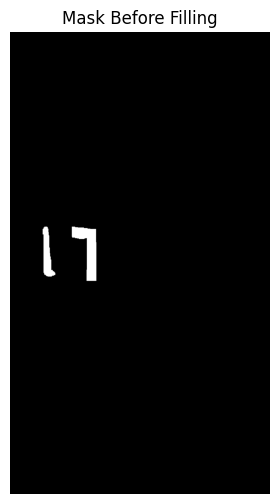

Initial fill complete. Running refinement...


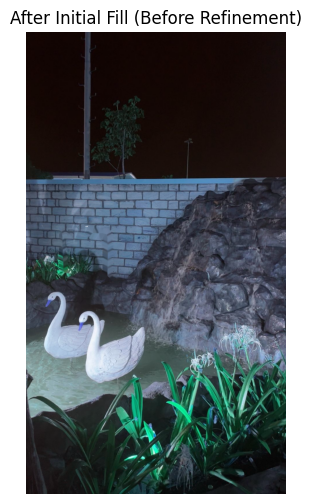

Refinement done.


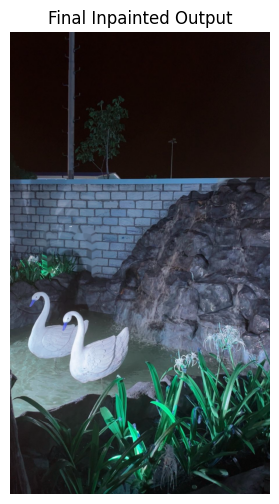

Saved output image to: /content/inpainted_output.png


In [30]:
result = inpaint_custom(image)

# --- Save Output Image Automatically in Colab Files ---
output_path = "/content/inpainted_output.png"
cv2.imwrite(output_path, result)
print(f"Saved output image to: {output_path}")

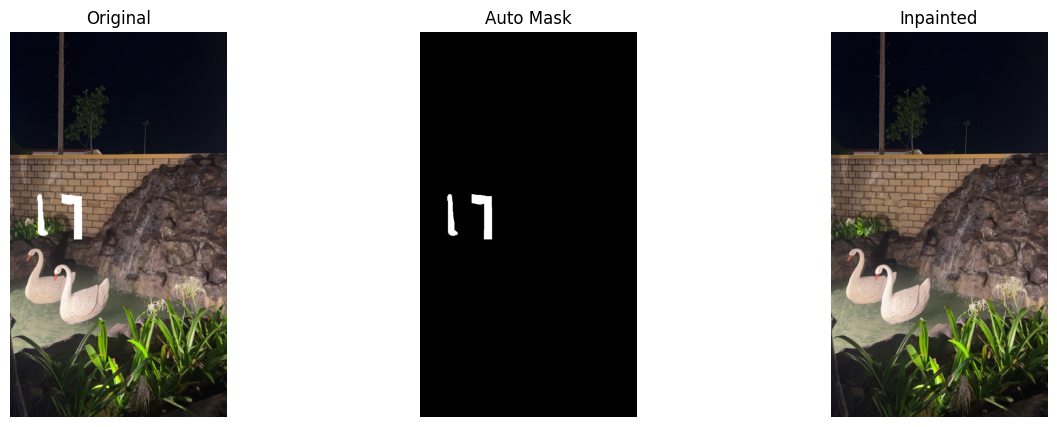

In [31]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(mask, cmap="gray")
plt.title("Auto Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title("Inpainted")
plt.axis("off")

plt.show()
